In [1]:
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import sqlite3 as sql

In [ ]:
# # Configurae the map (Pre-analysis)
# # Bound the window of the plot based on the data
# city_df = pd.read_parquet('city_df.parquet') # load the df from a .paraquet file
# lonc_min = city_df.lonc.min()
# lonc_med = city_df.lonc.median()
# lonc_max = city_df.lonc.max()

# cities = {} 
# cities['left'] = city_df[city_df.lonc == lonc_min].city.iloc[0]
# cities['right'] = city_df[city_df.lonc == lonc_max].city.iloc[0]
# print(f"the cities on the far left and right are {cities['left']} and {cities['right']}")

# # Extract the lonc and latc data given the city name. 
# # The ouputs are  city__.lonc and city__.latc
# city_left =  city_df[city_df.city == cities['left']][['lonc','latc']].iloc[0]
# city_right =  city_df[city_df.city == cities['right']][['lonc','latc']].iloc[0]

# latc_min = city_df.latc.min()
# latc_med = city_df.latc.median()
# latc_max = city_df.latc.max()

# # Create the plot on a geographic map usiong basemap
# m = Basemap(
#             projection ='lcc', 
#             resolution ='i', # intermediate
#             width = 1000000, # meters
#             height = 400000, # meters
#             lon_0 = lonc_med, # the median of the longtitdue data 
#             lat_0 = latc_med # the median of the latitude data 
#             )

# # Validate the selected window to see if it include both the cities with extreme coordinations
# loncs = [city_left.lonc, city_right.lonc] 
# latcs = [city_left.latc, city_right.latc]
# xi, yi = m(loncs, latcs)

# m.drawcountries()
# m.drawrivers()
# m.drawparallels(
#                 range(int(latc_min), int(latc_max)+3), 
#                 labels=[1,0,0,0] # show the label at the most left of the plot
#                 ) 

# m.drawmeridians(
#                 range(int(lonc_min),int(lonc_max),2),
#                 labels=[0,0,0,1]
#                 )
# m. scatter(xi, yi) 

# plt.show()

In [ ]:
# Read all the data from the SQL database
connection = sql.connect("data/minard.db")
table_names =  ["cities", "temperatures","troops"]

df = {}
for i, table in enumerate(table_names):
    query = f"Select * FROM {table};"
    df[table] = pd.read_sql(query, con=connection)

print("Finished loading all the three Dataframes")
connection.close()
# load the City data
loncs = df['cities']['lonc'].values # longitudes
latcs = df['cities']['latc'].values # latitudes
city_nms = df['cities']['city'].values # city names

# Calculate the geographical coordinates for the map's borders
lonc_min = df['cities']['lonc'].min() # the western edge of the map
lonc_max = df['cities']['lonc'].max() # the eastern edge of the map
lonc_med = df['cities']['lonc'].median() # the center of the map

latc_min = df['cities']['latc'].min() # the southern edge of the map
latc_max = df['cities']['latc'].max() # the northern edge of the map
latc_med = df['cities']['latc'].median() # the center of the map

# load the Temperature data
temp_cs = (df['temperatures']['temp']*4/5).values # convert the tempurature in to Celsius
lonts = df['temperatures']['lont'].values
dates = df['temperatures']['date'].values

# load the Troops data: The survival rate as a function of temperature and geographic coordination
lonps = df['troops']['lonp']
latps = df['troops']['latp']
survivs = df['troops']['surviv']
direcs = df['troops']['direc']
rows = len(df['troops']) # the rows of data point

Finished loading all the three Dataframes


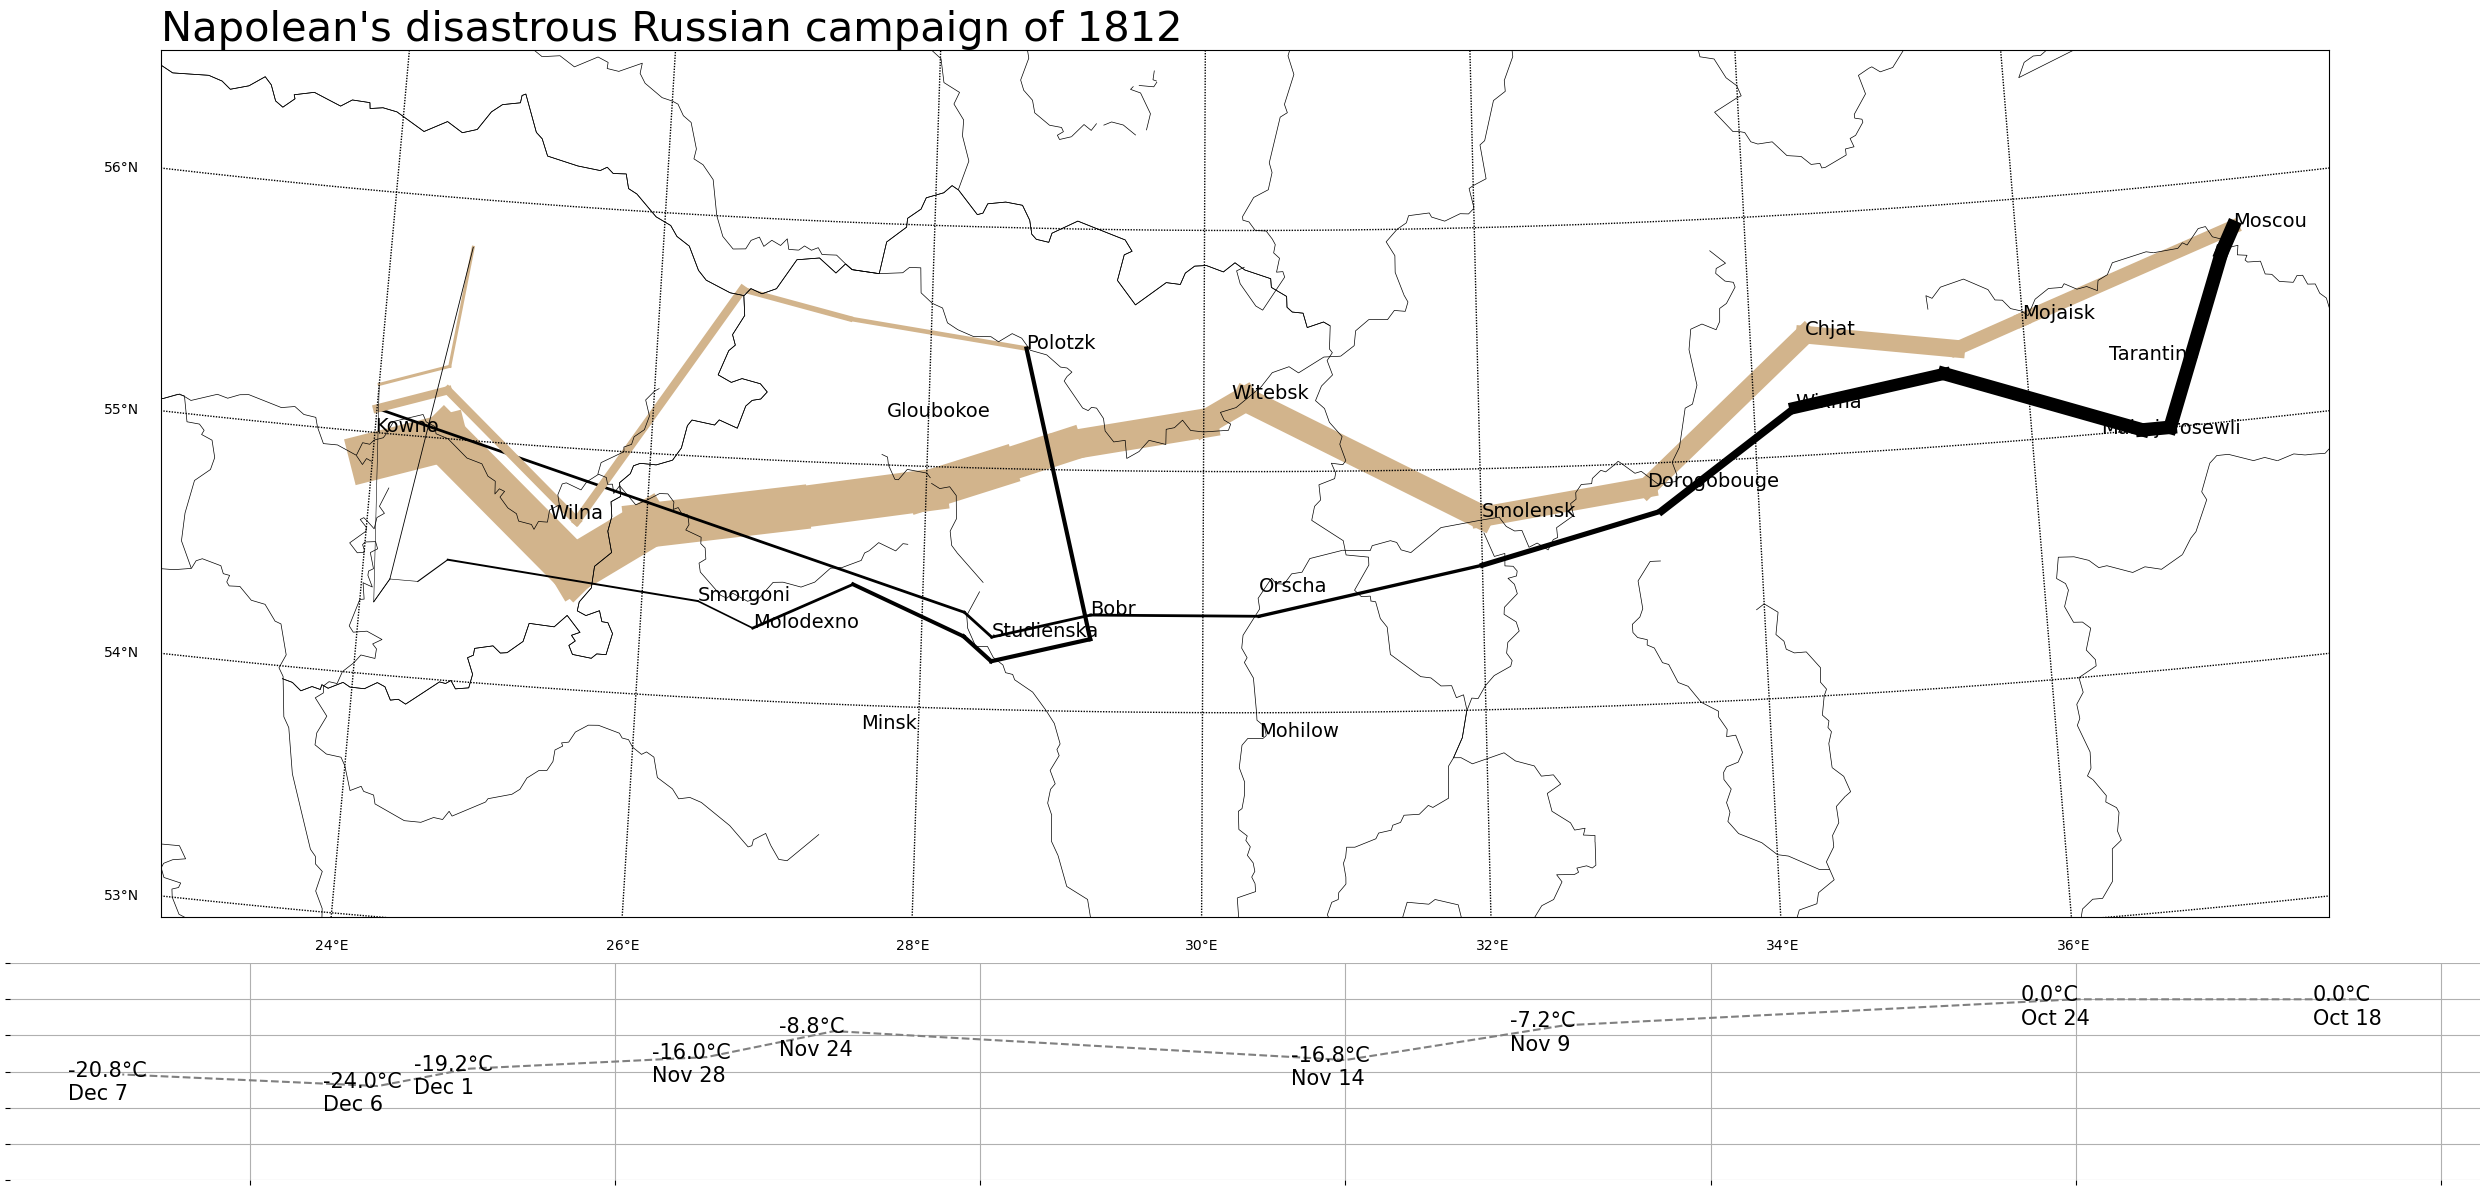

In [19]:
# Create the plot

# Draw the base map
fig, axes = plt.subplots(
                        nrows=2,  # split the plot into 2x2 subplots
                        figsize=(25, 12), 
                        gridspec_kw={"height_ratios":[4, 1]} # specify the height ratios for the plots on the first and second rows, respectively.
                        )
m = Basemap(
            projection ='lcc', 
            resolution ='i', # intermediate
            width = 1000000, # meters
            height = 400000, # meters
            lon_0 = lonc_med, # the median of the longtitdue data 
            lat_0 = latc_med, # the median of the latitude data 
            ax= axes[0]
            )
m.drawcountries()
m.drawrivers()
m.drawparallels(
                range(int(latc_min), int(latc_max)+3), 
                labels=[1,0,0,0] # show the label at the most left of the plot
                ) 

m.drawmeridians(
                range(int(lonc_min),int(lonc_max),2),
                labels=[0,0,0,1]
                )


#  Specify the city names on the map
x, y = m(loncs, latcs) # convert the coordinates to the (x,y) space on the map, m
for xi, yi, city in zip (x, y, city_nms):
    axes[0].annotate(text=city, xy=(xi,yi), fontsize=14,zorder=2) # add the city name on the coorinates
    
# Add troop directions on the map
x, y = m(lonps, latps) # convert the coordinates to the (x,y) space on the map, m
for r in range(0, rows-1): # the data is presented in pairwise (start-stop points), therefore the iteration should end before the last item
    if direcs[r] =='A':
        line_color = 'tan'
    else:
        line_color = 'black'
    start_stop_lonps = (x[r], x[r+1]) # start points
    start_stop_latps = (y[r], y[r+1]) # stop points 
    line_width = survivs[r]
    m.plot(start_stop_lonps,start_stop_latps, linewidth=line_width/10000, color=line_color, zorder=1)
    
# Plot the tempurture on each date across longitudes
axes[1].plot(lonts,temp_cs,linestyle='dashed', color='grey') 
temp_cs.astype(int)
annotations = [str(t)+"°C" +"\n"+ date for date, t in zip(dates, temp_cs)]

for lont, temp, anno in zip(lonts, temp_cs, annotations):
    axes[1].annotate(anno, xy=(lont-0.3, temp-7), fontsize=15) # adjust the coorinates to the lower left

# Adjust the axel of the seoncod plot 
axes[1].set_ylim(-50, 10)
axes[1].grid(True,which='major',axis='both')
axes[1].set_yticklabels([])
axes[1].set_xticklabels([])
borders = ['top','right','bottom','left']
for i in borders:
    axes[1].spines[f'{i}'].set_visible(False)
    
axes[0].set_title("Napolean's disastrous Russian campaign of 1812",loc='left',fontsize=30)
plt.tight_layout()
fig.savefig ('minard_clone.png')